In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.repeat(epsilon / nA, nA)
        action = np.argmax(Q[observation])
        pi[action] += 1 - epsilon
        return pi
        # Implement this!
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for episode in range(num_episodes):
        observation = env.reset()
        start_state = observation
        g = 0
        for t in range(100):
            pi = policy(observation)
            action = np.random.choice(range(env.nA), p=pi)
            if t == 0:
                a = action
            observation, reward, done, _ = env.step(action)
            g += discount_factor ** (t) * reward
            if done:
                k = start_state + (a,)
                returns_sum[k] += g
                returns_count[k] += 1
                break
    for k in returns_sum:
        Q[k[:-1]][k[-1]] = returns_sum[k] / returns_count[k]
    # 注意, make_epsilon_greedy_policy构造了一个闭包,并且传入了Q, Q是一个字典,相当于按引用传递,
    # 因此Q的改变会反应到policy上,所以我们不用在显式地更新policy了.
    return Q, policy

In [5]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

In [6]:
print(Q.keys())

dict_keys([(13, 7, False), (14, 10, False), (21, 10, False), (21, 4, True), (17, 4, False), (18, 6, False), (19, 6, False), (19, 2, False), (19, 9, False), (17, 10, True), (18, 10, False), (21, 8, True), (20, 4, False), (20, 5, False), (16, 5, False), (20, 10, False), (20, 10, True), (15, 5, False), (12, 6, False), (20, 3, False), (21, 5, True), (16, 6, False), (15, 10, False), (21, 10, True), (13, 2, False), (12, 4, False), (18, 7, False), (17, 3, False), (21, 4, False), (15, 9, False), (14, 9, False), (19, 3, False), (17, 9, False), (12, 10, False), (18, 9, False), (12, 7, False), (21, 8, False), (17, 10, False), (18, 1, False), (20, 7, True), (20, 8, False), (18, 4, True), (21, 1, True), (17, 5, False), (13, 10, False), (13, 1, False), (13, 10, True), (18, 2, False), (20, 2, False), (14, 7, False), (12, 2, False), (13, 3, False), (20, 7, False), (15, 2, False), (17, 6, False), (16, 9, False), (13, 5, False), (12, 9, False), (19, 10, False), (16, 1, False), (15, 8, False), (16, 8, Fa

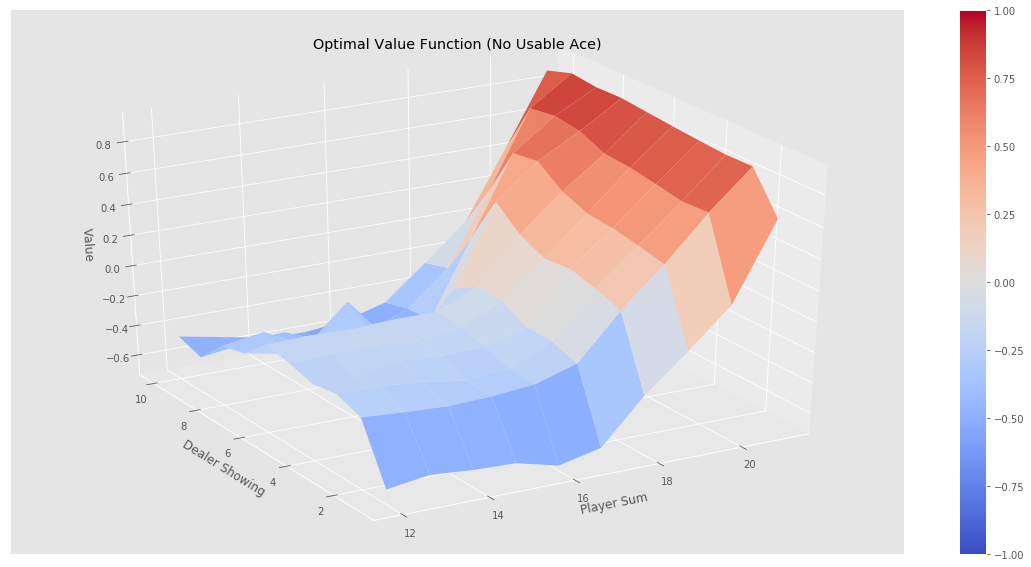

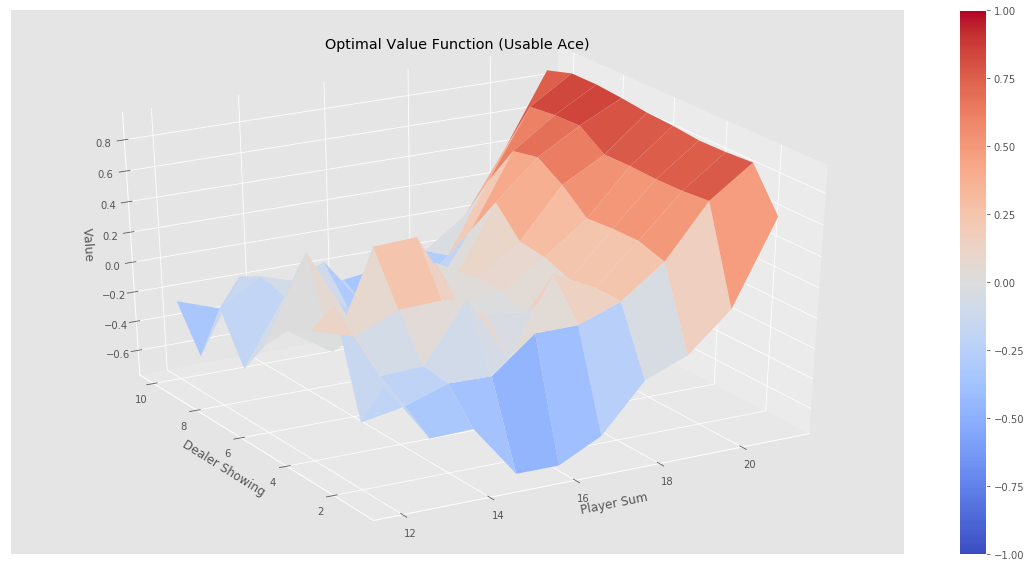

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")